In [1]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
import datetime
import math
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

2024-10-11 13:37:39.439446: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-11 13:37:39.502844: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-11 13:37:39.506408: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-11 13:37:39.571430: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-11 13:37:40.517369: W tensorflow/compiler/tf2

In [2]:
from tensorflow.keras import mixed_precision

# # Set the global policy to mixed precision
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_global_policy(policy)

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

I0000 00:00:1728614261.736696    4799 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728614262.645968    4799 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728614262.648132    4799 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [3]:
# import os

# # Set the environment variable
# os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [4]:
# data = pd.read_csv("C:\Users\alanx\OneDrive - The University of Sydney (Students)\Thesis\Deep Learning\wifi_localization\data\csv\ultimate_combined.csv")
# data = pd.read_csv("data/csv/ultimate_combined.csv")
data = pd.read_csv("data/csv/still/still.csv")

data.head()

,nc,rssi,rssi1,rssi2,subcarriers,ant1_amplitude,ant2_amplitude,ant1_phase,ant2_phase,with_receiver,coord1,coord2
0,2,-0.667067,-0.667125,-0.766719,1,-0.262284,-1.110773,-0.778041,1.226907,0,6,2
1,2,-0.667067,-0.667125,-0.766719,2,-0.215706,-0.189936,1.551789,-0.302208,0,6,2
2,2,-0.667067,-0.667125,-0.766719,3,-0.139639,-1.025264,-0.776073,1.202311,0,6,2
3,2,-0.667067,-0.667125,-0.766719,4,-0.155821,-0.097732,1.538581,-0.313973,0,6,2
4,2,-0.667067,-0.667125,-0.766719,5,-0.085535,-0.980426,-0.790887,1.234688,0,6,2


In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


I0000 00:00:1728614275.187862    4799 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728614275.190173    4799 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728614275.192593    4799 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728614275.296306    4799 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [7]:
# variances = data.var()
# print(variances)

# low_variance_cols = variances[variances < 5e-3].index.tolist()
# print("Columns with low or zero variance:")
# print(low_variance_cols)

In [8]:
# # Drop constant columns and timeframe from the DataFrame
# data.drop(low_variance_cols, axis=1, inplace=True)
# data.drop(['csi_len', 'rate', 'payload_length', 'block_length'], axis=1, inplace=True)
# data.drop('timestamps', axis=1, inplace=True)
# data.head()

In [9]:
# # features_to_scale = ['csi_len', 'payload_length', 'block_length', 'ant1_amplitude', 'ant2_amplitude', 'ant1_phase', 'ant2_phase', 'rssi', 'rssi1', 'rssi2']
# features_to_scale = ['ant1_amplitude', 'ant2_amplitude', 'ant1_phase', 'ant2_phase', 'rssi', 'rssi1', 'rssi2']
features_to_scale = ['ant1_amplitude', 'ant2_amplitude']
scaler = StandardScaler()

# Apply standardization on features
# data = data_cleaned.copy()
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])
data.head()

,nc,rssi,rssi1,rssi2,subcarriers,ant1_amplitude,ant2_amplitude,ant1_phase,ant2_phase,with_receiver,coord1,coord2
0,2,-0.667067,-0.667125,-0.766719,1,-0.262284,-1.110773,-0.778041,1.226907,0,6,2
1,2,-0.667067,-0.667125,-0.766719,2,-0.215706,-0.189936,1.551789,-0.302208,0,6,2
2,2,-0.667067,-0.667125,-0.766719,3,-0.139639,-1.025264,-0.776073,1.202311,0,6,2
3,2,-0.667067,-0.667125,-0.766719,4,-0.155821,-0.097732,1.538581,-0.313973,0,6,2
4,2,-0.667067,-0.667125,-0.766719,5,-0.085535,-0.980426,-0.790887,1.234688,0,6,2


In [10]:
# # Step 1: Extract your data (using the amplitude data as an example)
# X = data[['ant1_amplitude', 'ant2_amplitude']].values

# # Step 2: Use Nearest Neighbors to find the k nearest neighbors
# k = 49  # min_samples - 1 for DBSCAN, for example, min_samples = 5, so k = 4
# neighbors = NearestNeighbors(n_neighbors=k)
# neighbors_fit = neighbors.fit(X)
# distances, indices = neighbors_fit.kneighbors(X)

# # Step 3: Sort the distances to the k-th nearest neighbor
# # The distance to the k-th nearest neighbor is in the last column (index k-1)
# k_distances = distances[:, k-1]
# k_distances = np.sort(k_distances)

# # Step 4: Plot the sorted k-distance graph
# plt.figure(figsize=(8, 5))
# plt.plot(k_distances)
# plt.xlabel('Points sorted by distance to {}-th nearest neighbor'.format(k))
# plt.ylabel('{}-th nearest neighbor distance'.format(k))
# plt.title('K-Distance Graph (Elbow Method for DBSCAN)')
# plt.grid(True)
# plt.show()

In [11]:
# amplitudes = data[['ant1_amplitude', 'ant2_amplitude']].values

In [12]:
# dbscan = hdbscan.HDBSCAN(min_samples=10, core_dist_n_jobs=-1)

In [13]:
# dbscan = DBSCAN(eps=0.1, min_samples=50)

In [14]:
# data_sample = data.sample(frac=0.1)
# amplitudes = data_sample[['ant1_amplitude', 'ant2_amplitude']].values

In [15]:
# dbscan.fit(amplitudes)

In [16]:
# # Step 4: Add the cluster labels to the dataframe
# data['cluster'] = dbscan.labels_

# data.head()

# # Step 5: Visualize the clusters
# plt.scatter(data['ant1_amplitude'], data['ant2_amplitude'], c=data['cluster'], cmap='viridis', alpha=0.6)
# plt.xlabel('Ant1 Amplitude')
# plt.ylabel('Ant2 Amplitude')
# plt.title('DBSCAN Clustering on Amplitude Data')
# plt.colorbar(label='Cluster Label')
# plt.show()

In [17]:
data.drop('with_receiver', axis=1, inplace=True)

In [18]:
data = pd.concat([data, pd.get_dummies(data['subcarriers'], prefix='subcarrier')], axis=1)
data.drop('subcarriers', axis=1, inplace=True)
data.head()

,nc,rssi,rssi1,rssi2,ant1_amplitude,ant2_amplitude,ant1_phase,ant2_phase,coord1,coord2,...,subcarrier_47,subcarrier_48,subcarrier_49,subcarrier_50,subcarrier_51,subcarrier_52,subcarrier_53,subcarrier_54,subcarrier_55,subcarrier_56
0,2,-0.667067,-0.667125,-0.766719,-0.262284,-1.110773,-0.778041,1.226907,6,2,...,False,False,False,False,False,False,False,False,False,False
1,2,-0.667067,-0.667125,-0.766719,-0.215706,-0.189936,1.551789,-0.302208,6,2,...,False,False,False,False,False,False,False,False,False,False
2,2,-0.667067,-0.667125,-0.766719,-0.139639,-1.025264,-0.776073,1.202311,6,2,...,False,False,False,False,False,False,False,False,False,False
3,2,-0.667067,-0.667125,-0.766719,-0.155821,-0.097732,1.538581,-0.313973,6,2,...,False,False,False,False,False,False,False,False,False,False
4,2,-0.667067,-0.667125,-0.766719,-0.085535,-0.980426,-0.790887,1.234688,6,2,...,False,False,False,False,False,False,False,False,False,False


# Model

In [19]:
model_type = "dnn"

In [20]:
X = data.drop(columns=['coord1', 'coord2']) 
y = data[['coord1', 'coord2']]

# X = X.values.astype(np.float32)
# y = y.values.astype(np.float32)

In [21]:
# np.save('preprocessed_X.npy', X)
# np.save('preprocessed_y.npy', y)

In [22]:
# X = np.load('preprocessed_X.npy')
# y = np.load('preprocessed_y.npy')

In [23]:
# dataset = tf.data.Dataset.from_tensor_slices((X, y))

# batch_size = 128  # Adjust based on your GPU memory

# dataset = dataset.shuffle(buffer_size=10000)
# dataset = dataset.batch(batch_size)
# dataset = dataset.prefetch(tf.data.AUTOTUNE)

In [24]:
# First, split the data into training and a temporary set (which will later be split into validation and test sets)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)  # 60% train, 40% temp

# Now, split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 20% val, 20% test

# Check the shapes of your splits
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (7484064, 64)
Validation set shape: (2494688, 64)
Test set shape: (2494688, 64)


In [25]:
def create_dnn_model(input_shape):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))

    # Hidden layers
    # model.add(layers.Dense(8192, activation='relu'))
    # model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dense(2048, activation='relu'))
    model.add(layers.Dense(2048, activation='relu'))
    model.add(layers.Dense(2048, activation='relu'))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))

    # Output layer
    model.add(layers.Dense(2))

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


# Example of creating the model, input_shape should be (number of features,)
input_shape = (X_train.shape[1],)  # Adjust based on your number of features
model = create_dnn_model(input_shape)

# Print the model summary
model.summary()

/home/alan-xie/Documents/Thesis/wifi_localization/.venv/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
I0000 00:00:1728614283.311197    4799 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728614283.312422    4799 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728614283.313589    4799 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA no

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2048)           │       133,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,323,922 (43.20 MB)

 Trainable params: 11,323,922 (43.20 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")
# Train the model
with tf.device('/GPU:0'):
    history = model.fit(
                        # dataset,
                        X_train, y_train, 
                        epochs=30, 
                        batch_size=128, 
                        validation_data=(X_val, y_val),
                        callbacks=[tensorboard_callback, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

    # Evaluate the model on test data
    test_loss, test_mae = model.evaluate(X_test, y_test)
    print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")


2024-10-11 13:38:05.919729: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1915920384 exceeds 10% of free system memory.
2024-10-11 13:38:06.750758: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 119745024 exceeds 10% of free system memory.
2024-10-11 13:38:06.798700: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1915920384 exceeds 10% of free system memory.
2024-10-11 13:38:07.426467: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 119745024 exceeds 10% of free system memory.


Epoch 1/30


2024-10-11 13:38:07.721405: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 59872512 exceeds 10% of free system memory.
I0000 00:00:1728614289.316988    7834 service.cc:146] XLA service 0x7a49d40065f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728614289.317005    7834 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-10-11 13:38:09.353690: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-11 13:38:09.709354: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-11 13:38:10.476926: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_405', 132 bytes spill stores, 132 bytes spill loads

2024-10-11 1

   33/58470 ━━━━━━━━━━━━━━━━━━━━ 3:08 3ms/step - loss: 14.2353 - mae: 3.0611   

I0000 00:00:1728614299.899211    7834 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


58455/58470 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5595 - mae: 1.2720

2024-10-11 13:41:14.743081: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_405', 4 bytes spill stores, 4 bytes spill loads

2024-10-11 13:41:14.794585: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_433', 132 bytes spill stores, 132 bytes spill loads

2024-10-11 13:41:14.939802: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_433', 16 bytes spill stores, 16 bytes spill loads

2024-10-11 13:41:15.470088: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_447', 132 bytes spill stores, 132 bytes spill loads

2024-10-11 13:41:15.739413: I external/local_xla/xla/stream_ex

58470/58470 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5593 - mae: 1.2719

2024-10-11 13:41:38.974881: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_42', 132 bytes spill stores, 132 bytes spill loads

2024-10-11 13:41:39.113365: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_42', 376 bytes spill stores, 284 bytes spill loads

2024-10-11 13:41:39.190187: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_56', 132 bytes spill stores, 132 bytes spill loads

2024-10-11 13:41:39.329424: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_42', 16 bytes spill stores, 16 bytes spill loads

2024-10-11 13:41:39.624332: I external/local_xla/xla/stream_ex

58470/58470 ━━━━━━━━━━━━━━━━━━━━ 215s 3ms/step - loss: 2.5593 - mae: 1.2719 - val_loss: 0.9290 - val_mae: 0.5981
Epoch 2/30
58470/58470 ━━━━━━━━━━━━━━━━━━━━ 183s 3ms/step - loss: 0.8032 - mae: 0.5351 - val_loss: 0.5717 - val_mae: 0.4208
Epoch 3/30
58470/58470 ━━━━━━━━━━━━━━━━━━━━ 184s 3ms/step - loss: 0.5580 - mae: 0.4054 - val_loss: 0.4787 - val_mae: 0.3620
Epoch 4/30
58470/58470 ━━━━━━━━━━━━━━━━━━━━ 183s 3ms/step - loss: 0.4418 - mae: 0.3420 - val_loss: 0.3453 - val_mae: 0.3039
Epoch 5/30
58470/58470 ━━━━━━━━━━━━━━━━━━━━ 183s 3ms/step - loss: 0.3710 - mae: 0.3018 - val_loss: 0.3906 - val_mae: 0.3070
Epoch 6/30
58470/58470 ━━━━━━━━━━━━━━━━━━━━ 181s 3ms/step - loss: 0.3250 - mae: 0.2757 - val_loss: 0.2528 - val_mae: 0.2413
Epoch 7/30
58470/58470 ━━━━━━━━━━━━━━━━━━━━ 178s 3ms/step - loss: 0.2896 - mae: 0.2531 - val_loss: 0.2577 - val_mae: 0.2384
Epoch 8/30
58470/58470 ━━━━━━━━━━━━━━━━━━━━ 178s 3ms/step - loss: 0.2667 - mae: 0.2400 - val_loss: 0.2354 - val_mae: 0.2235
Epoch 9/30
58470/58

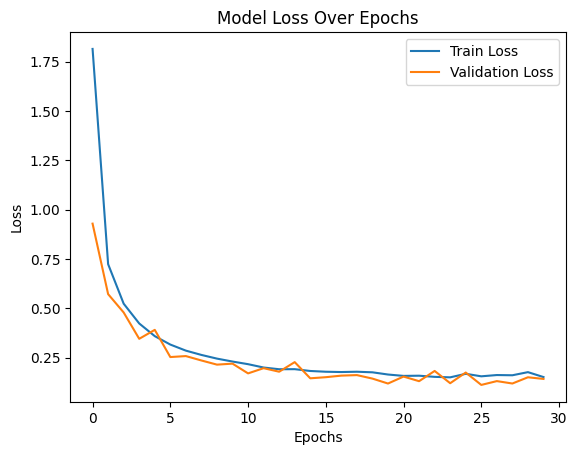

In [27]:
# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [28]:
# After training your model
y_pred = model.predict(X_test)

77959/77959 ━━━━━━━━━━━━━━━━━━━━ 53s 665us/step


In [29]:
# Convert y_test to NumPy array with float64 data type
y_test_np = y_test.to_numpy(dtype=np.float64)

# Ensure y_pred is a NumPy array with float64 data type
y_pred_np = np.array(y_pred, dtype=np.float64)

In [30]:
# Assuming y_test and y_pred are NumPy arrays
absolute_errors = np.abs(y_test_np - y_pred_np)
coordinate_ranges = np.ptp(y_test_np, axis=0)  # Peak to peak (max - min) along each coordinate

# Avoid division by zero
coordinate_ranges[coordinate_ranges == 0] = 1

relative_errors = absolute_errors / coordinate_ranges
mean_relative_error = np.mean(relative_errors, axis=0)

print(f"Mean Relative Error for coord1: {mean_relative_error[0]:.4f}")
print(f"Mean Relative Error for coord2: {mean_relative_error[1]:.4f}")


Mean Relative Error for coord1: 0.0284
Mean Relative Error for coord2: 0.0322


In [31]:
from scipy.stats import spearmanr

rho_coord1, _ = spearmanr(y_test_np[:, 0], y_pred_np[:, 0])
rho_coord2, _ = spearmanr(y_test_np[:, 1], y_pred_np[:, 1])

print(f"Spearman's Rank Correlation for coord1: {rho_coord1:.4f}")
print(f"Spearman's Rank Correlation for coord2: {rho_coord2:.4f}")


Spearman's Rank Correlation for coord1: 0.9714
Spearman's Rank Correlation for coord2: 0.9571


In [32]:
# Create a mapping from coordinate pairs to class labels
unique_coords = np.unique(y_test_np, axis=0)
coord_to_label = {tuple(coord): idx for idx, coord in enumerate(unique_coords)}

# Convert coordinates to labels
y_test_labels = np.array([coord_to_label[tuple(coord)] for coord in y_test_np])
y_pred_labels = np.array([coord_to_label.get(tuple(coord), -1) for coord in y_pred_np])  # Use -1 for unknowns


In [33]:
# from sklearn.metrics import accuracy_score, confusion_matrix

# # Filter out predictions that don't map to a valid label
# valid_indices = y_pred_labels != -1
# accuracy = accuracy_score(y_test_labels[valid_indices], y_pred_labels[valid_indices])
# print(f"Classification Accuracy: {accuracy:.4f}")


In [34]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import ConfusionMatrixDisplay

# cm = confusion_matrix(y_test_labels[valid_indices], y_pred_labels[valid_indices])
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(cmap='Blues')
# plt.title('Confusion Matrix of Predicted vs Actual Classes')
# plt.show()

In [35]:
scaler = StandardScaler()
y_test_scaled = scaler.fit_transform(y_test_np)
y_pred_scaled = scaler.transform(y_pred_np)

# Compute Mean Squared Error on standardized data
from sklearn.metrics import mean_squared_error

mse_scaled = mean_squared_error(y_test_scaled, y_pred_scaled)
print(f"MSE on Standardized Coordinates: {mse_scaled:.4f}")


MSE on Standardized Coordinates: 0.0474


In [36]:
def custom_accuracy(y_true, y_pred, tolerance):
    # Count predictions within a certain tolerance
    correct_predictions = np.all(np.abs(y_true - y_pred) <= tolerance, axis=1)
    accuracy = np.mean(correct_predictions)
    return accuracy

tolerances = [1, 0.5, 0.1]  # Adjust based on your coordinate system

for tolerance in tolerances:
    accuracy = custom_accuracy(y_test_np, y_pred_np, tolerance)
    print(f"Accuracy within tolerance {tolerance}: {accuracy:.4f}")

accuracy = custom_accuracy(y_test_np, y_pred_np, 1)

Accuracy within tolerance 1: 0.9518
Accuracy within tolerance 0.5: 0.8878
Accuracy within tolerance 0.1: 0.4570


In [37]:
tolerances = [1, 0.5, 0.1]  # Adjust based on your coordinate system

y_pred_np_rounded = np.round(y_pred_np)

for tolerance in tolerances:
    accuracy = custom_accuracy(y_test_np, y_pred_np_rounded, tolerance)
    print(f"Accuracy within tolerance {tolerance}: {accuracy:.4f}")

accuracy = custom_accuracy(y_test_np, y_pred_np, 1)

Accuracy within tolerance 1: 0.9757
Accuracy within tolerance 0.5: 0.8878
Accuracy within tolerance 0.1: 0.8878


/home/alan-xie/Documents/Thesis/wifi_localization/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


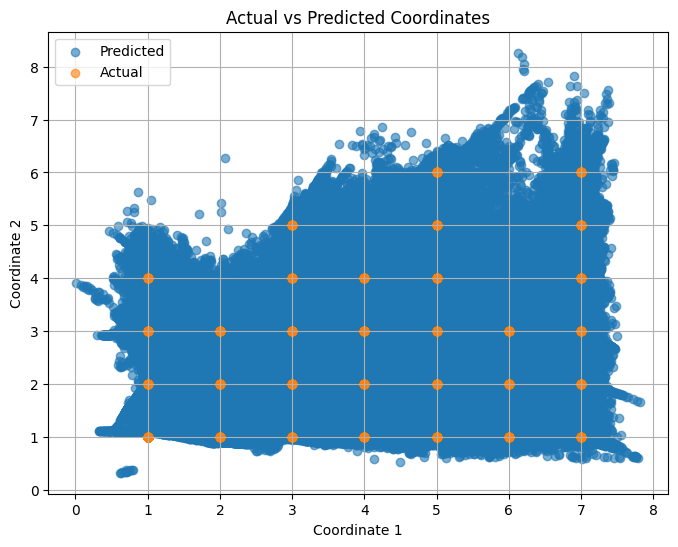

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_pred_np[:, 0], y_pred_np[:, 1], label='Predicted', alpha=0.6)
plt.scatter(y_test_np[:, 0], y_test_np[:, 1], label='Actual', alpha=0.6)
plt.xlabel('Coordinate 1')
plt.ylabel('Coordinate 2')
plt.title('Actual vs Predicted Coordinates')
plt.legend()
plt.grid(True)
plt.show()


In [39]:
# MAE for each coordinate
mae_coord1 = mean_absolute_error(y_test_np[:, 0], y_pred_np[:, 0])
mae_coord2 = mean_absolute_error(y_test_np[:, 1], y_pred_np[:, 1])

# Overall MAE
mae_overall = np.mean([mae_coord1, mae_coord2])

print(f"MAE for coord1: {mae_coord1:.4f}")
print(f"MAE for coord2: {mae_coord2:.4f}")
print(f"Overall MAE: {mae_overall:.4f}")

# RMSE for each coordinate
rmse_coord1 = np.sqrt(mean_squared_error(y_test_np[:, 0], y_pred_np[:, 0]))
rmse_coord2 = np.sqrt(mean_squared_error(y_test_np[:, 1], y_pred_np[:, 1]))

# Overall RMSE
rmse_overall = np.mean([rmse_coord1, rmse_coord2])

print(f"RMSE for coord1: {rmse_coord1:.4f}")
print(f"RMSE for coord2: {rmse_coord2:.4f}")
print(f"Overall RMSE: {rmse_overall:.4f}")

# Calculate Euclidean distances
distance_errors = np.linalg.norm(y_test_np - y_pred_np, axis=1)
mean_distance_error = np.mean(distance_errors)

print(f"Mean Euclidean Distance Error: {mean_distance_error:.4f} units")

# R-squared for each coordinate
r2_coord1 = r2_score(y_test_np[:, 0], y_pred_np[:, 0])
r2_coord2 = r2_score(y_test_np[:, 1], y_pred_np[:, 1])

print(f"R-squared for coord1: {r2_coord1:.4f}")
print(f"R-squared for coord2: {r2_coord2:.4f}")

# Median Absolute Error for each coordinate
medae_coord1 = median_absolute_error(y_test_np[:, 0], y_pred_np[:, 0])
medae_coord2 = median_absolute_error(y_test_np[:, 1], y_pred_np[:, 1])

print(f"Median Absolute Error for coord1: {medae_coord1:.4f}")
print(f"Median Absolute Error for coord2: {medae_coord2:.4f}")

MAE for coord1: 0.1703
MAE for coord2: 0.1609
Overall MAE: 0.1656
RMSE for coord1: 0.4018
RMSE for coord2: 0.3500
Overall RMSE: 0.3759
Mean Euclidean Distance Error: 0.2648 units
R-squared for coord1: 0.9596
R-squared for coord2: 0.9456
Median Absolute Error for coord1: 0.0739
Median Absolute Error for coord2: 0.0715


In [40]:
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import make_scorer

# def mean_euclidean_error(y_true, y_pred):
#     return np.mean(np.linalg.norm(y_true - y_pred, axis=1))

# # Create a scorer based on your custom metric
# scorer = make_scorer(mean_euclidean_error, greater_is_better=False)

# # Assuming you have a model compatible with scikit-learn's API
# scores = cross_val_score(model, X, y, cv=5, scoring=scorer)
# print(f"Cross-validated Mean Euclidean Distance Error: {-np.mean(scores):.4f}")


In [41]:
now = datetime.datetime.now()
date_time = now.strftime("%m-%d-%H-%M")

model.save(f"./models/{date_time}-{model_type}-{accuracy:.2f}.keras")